Torch Implementation of GP

Inspired by: https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html



In [84]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import time

from data import Dataprep, update_data, load_data
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import pandas as pd


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
dataset_type='Generated_2000'
sensor='foundation_origin xy FloaterOffset [m]'
samples_per_step=10
validation_size=0.1

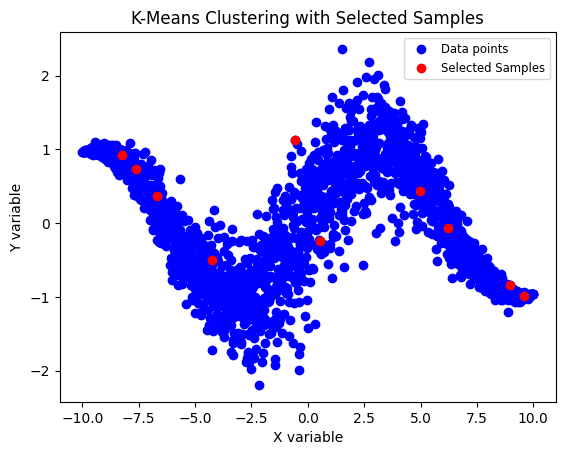

In [166]:
data = Dataprep(dataset_type, sensor, initial_samplesize=samples_per_step)
known_data, pool_data = data.known_data, data.pool_data

Load Data and Normalize

In [167]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Assuming you have an RBFKernel instance named `rbf_kernel`:
        rbf_kernel = gpytorch.kernels.RBFKernel()

        # To set an initial length scale:
        rbf_kernel.lengthscale = 0.1

        # kernel can be changed or combined !
        self.covar_module = gpytorch.kernels.ScaleKernel(rbf_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = ExactGPModel(train_x, train_y, likelihood)

In [168]:
from torch.optim import Adam

In [169]:
def init_optimizer(learning_rate,model):
    optimizer = Adam(model.parameters(), lr=learning_rate)
    return optimizer
    
def train_model(step, learning_rate):
    print('K_D, P_D', known_data.shape, pool_data.shape)

    # Split the pool data into train and validation sets
    train, val = train_test_split(known_data, test_size=validation_size)

    X_train = torch.tensor(scaler.fit_transform(train[:, 0].reshape(-1, 1))).to(device)  # Adds an extra dimension to make X_train a 2D tensor
    y_train = torch.tensor(train[:, 1]).to(device)
    
    # Initialize likelihood and model with training data
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    # Assuming you have a GaussianLikelihood instance named `likelihood`:
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # To set an initial noise level:
    likelihood.noise = 0.01






    model = ExactGPModel(X_train, y_train, likelihood).to(device)
    
    optimizer = init_optimizer(learning_rate,model) # Initialize the optimizer

    model.train()
    likelihood.train()

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    total_train_loss = 0

    x, y = X_train, y_train

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for epoch in range(epochs):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X_train)
        # Calc loss and backprop gradients
        loss = -mll(output, y_train)
        loss.backward()
        print('Epoch %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            epoch +1, epochs, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

    preds = evaluate_model(likelihood, model,val, step, mll) # Evaluate the model on the validation set

    return preds


In [170]:
def evaluate_model(likelihood, model,val_loader, step, mll): # 1: EVALUATE THE MODEL ON THE VALIDATION SET

    X_val = torch.tensor(scaler.fit_transform(val[:, 0].reshape(-1, 1))).to(device)  # Adds an extra dimension to make X_train a 2D tensor
    y_val = torch.tensor(val[:, 1]).to(device)
    x, y = X_val, y_val
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    total_val_loss = 0
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(0, 1, 51)
        observed_pred = likelihood(model(X_val))
        output = model(X_val)
        loss = -mll(output, y_val)
        total_val_loss += loss.item()

    step_val_loss = total_val_loss  # Average loss over batches
    writer.add_scalar('loss/val', step_val_loss, step+1)
    if verbose:
        print('Step: {}, Val-Loss: {:.4f}'.format(step+1, step_val_loss))

    if known_data.shape[1] == 2:
        preds = plot(likelihood, model, step)
    return preds

In [171]:
def plot(likelihood, model, step, samples=500):
    x_pool = pool_data[:, :-1]
    y_pool = pool_data[:, -1]

    x_selected = known_data[:, :-1]
    y_selected = known_data[:, -1]

    scaler = MinMaxScaler()
    x_pool_scaled = scaler.fit_transform(x_pool)
    x_selected_scaled = scaler.transform(x_selected)
    
    x_pool_torch = torch.tensor(x_pool_scaled) 

    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(x_pool_torch))

    means = preds.mean.numpy()  # calculate the mean of the predictions
    lower, upper = preds.confidence_region()
    stds = preds.stddev.numpy()
    
    # Prepare data for plotting
    #df = pd.DataFrame({'x': x_pool_torch.squeeze(), 'mean': means.squeeze(), 'lower': lower, 'upper': upper})

    dfs = []
    y_vals = [means, means + 2 * stds, means - 2 * stds]

    for i in range(3): #len(y_vals)
        dfs.append(pd.DataFrame({'x': x_pool_torch.squeeze(), 'y': y_vals[i].squeeze()}))
    df = pd.concat(dfs)

    print(means.squeeze())
    
    # Plotting
    fig = plt.figure()
    sns.lineplot(data=df, x="x", y="y")
    plt.scatter(x_pool_scaled, y_pool, c="green", marker="*", alpha=0.1)  # Plot actual y values
    plt.scatter(x_selected_scaled, y_selected, c="red", marker="*", alpha=0.2) # plot train data on top
    plt.title(f'Predictions vs Actual Step {step+1}')
    plt.legend(['Mean prediction', 'Pool data (unseen)', 'Seen data'], fontsize='small')
    plt.close(fig)

    # Log the table figure
    writer.add_figure(f'Prediction vs Actual Table Epoch {step+1}', fig, step+1)

    # Log the table figure
    writer.add_figure(f'Prediction vs Actual Table Epoch {step+1}', fig, step+1)

    return preds

In [172]:
import random

In [173]:
def predict(self, x): # 2: PREDICT THE UNCERTAINTY ON THE POOL DATA
        pass

def acquisition_function(n, pool_data=pool_data, known_data=known_data): # 3: DECIDE WHICH SAMPLES TO SELECT FROM THE POOL DATA (USING ACQUISITION FUNCTION)
    selected_indices = random.sample(range(len(pool_data)), n)
    known_data, pool_data = update_data(known_data, pool_data, selected_indices)

    return known_data, pool_data

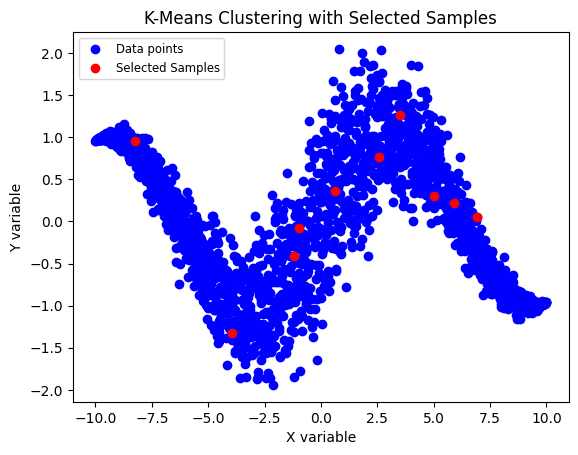

In [174]:
data = Dataprep(dataset_type, sensor, initial_samplesize=samples_per_step)
known_data, pool_data = data.known_data, data.pool_data

In [175]:
from torch.utils.tensorboard import SummaryWriter
import datetime
import os

In [176]:
steps = 10
learning_rate = 0.01
epochs = 150
verbose=True
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # Unique directory based on datetime for each run
log_dir = os.path.join('Models/runs', 'BNN_' + dataset_type  + '_' + current_time)
writer = SummaryWriter(log_dir) 

device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")

In [177]:
known_data, pool_data = data.known_data, data.pool_data

In [178]:
# Train the model
for step in range(steps):
    start_step = time.time()
    preds = train_model(step,learning_rate) # Train the model
    print('Step: {} of {}, time-taken: {:.2f} seconds'.format(step+1, steps, time.time() - start_step))
    known_data, pool_data = acquisition_function(samples_per_step, pool_data, known_data) # Select the next samples from the pool

K_D, P_D (10, 2) (1990, 2)
Epoch 1/150 - Loss: 0.955   lengthscale: 0.100   noise: 0.010
Epoch 2/150 - Loss: 0.927   lengthscale: 0.091   noise: 0.011
Epoch 3/150 - Loss: 0.931   lengthscale: 0.085   noise: 0.012
Epoch 4/150 - Loss: 0.935   lengthscale: 0.083   noise: 0.013
Epoch 5/150 - Loss: 0.932   lengthscale: 0.082   noise: 0.014
Epoch 6/150 - Loss: 0.926   lengthscale: 0.084   noise: 0.015
Epoch 7/150 - Loss: 0.920   lengthscale: 0.086   noise: 0.016
Epoch 8/150 - Loss: 0.917   lengthscale: 0.088   noise: 0.018
Epoch 9/150 - Loss: 0.917   lengthscale: 0.091   noise: 0.019
Epoch 10/150 - Loss: 0.919   lengthscale: 0.093   noise: 0.020
Epoch 11/150 - Loss: 0.919   lengthscale: 0.094   noise: 0.022
Epoch 12/150 - Loss: 0.917   lengthscale: 0.095   noise: 0.024
Epoch 13/150 - Loss: 0.914   lengthscale: 0.095   noise: 0.026
Epoch 14/150 - Loss: 0.912   lengthscale: 0.095   noise: 0.029
Epoch 15/150 - Loss: 0.911   lengthscale: 0.095   noise: 0.031
Epoch 16/150 - Loss: 0.912   lengthsc

In [159]:
preds

MultivariateNormal(loc: torch.Size([1000]))

In [160]:
preds[0].mean.numpy()

array(-0.58365375, dtype=float32)

In [161]:
len(preds.stddev)


1000